# ML Pipeline for Adult Census Data

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.feature_selection import RFE, f_regression
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, RandomizedLasso)
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor

### Load and Format Data

In [2]:
census = pd.DataFrame.from_csv('adult.csv', index_col=None)

In [3]:
# replace '.' in heading columns

census.columns = census.columns.str.replace(".", "_")

In [4]:
# re-format income values; 1 = greater than 50k, 0 = less than 50k

census.income = census.income.str.replace('>50K', '1')
census.income = census.income.str.replace('<=50K', '0')
census.income = census.income.astype('int64')

In [5]:
# replace '?'s in data with NaNs

census = census.replace(to_replace='?',value=np.nan)

In [6]:
# fill in null birth country information with 'United-States'; it is the most common 
census.native_country = census.native_country.fillna('United-States')

In [7]:
len(census)

32561

### Explore Data

In [8]:
#identify data types of columns 

g = census.columns.to_series().groupby(census.dtypes).groups
print(g)

{dtype('int64'): Index(['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss',
       'hours_per_week', 'income'],
      dtype='object'), dtype('O'): Index(['workclass', 'education', 'marital_status', 'occupation',
       'relationship', 'race', 'sex', 'native_country'],
      dtype='object')}


In [9]:
census.fnlwgt[0]

77053

In [10]:
census.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,0
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,0
2,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,0
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,0
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,0


In [11]:
# define numeric and categorical variables

num_var = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss',
       'hours_per_week', 'income']

cat_var = ['workclass', 'education', 'marital_status', 'occupation',
       'relationship', 'race', 'sex', 'native_country']

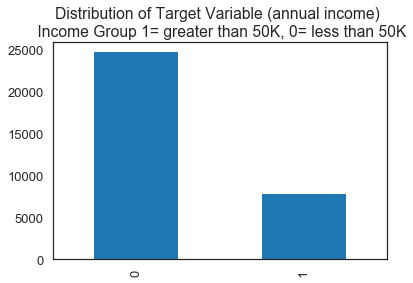

In [12]:
# count target variable

sns.set_context("talk")
sns.set_style("white")

census['income'].value_counts().plot.bar()
plt.title('Distribution of Target Variable (annual income) \n Income Group 1= greater than 50K, 0= less than 50K')
plt.show()

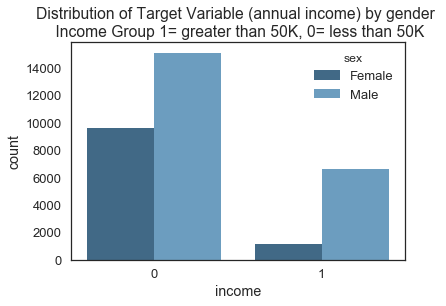

In [13]:
# count target variable
sns.set_context("talk")
sns.set_style("white")

sns.countplot(x="income", hue="sex", data=census, palette="Blues_d")
plt.title('Distribution of Target Variable (annual income) by gender \n Income Group 1= greater than 50K, 0= less than 50K')
plt.show()

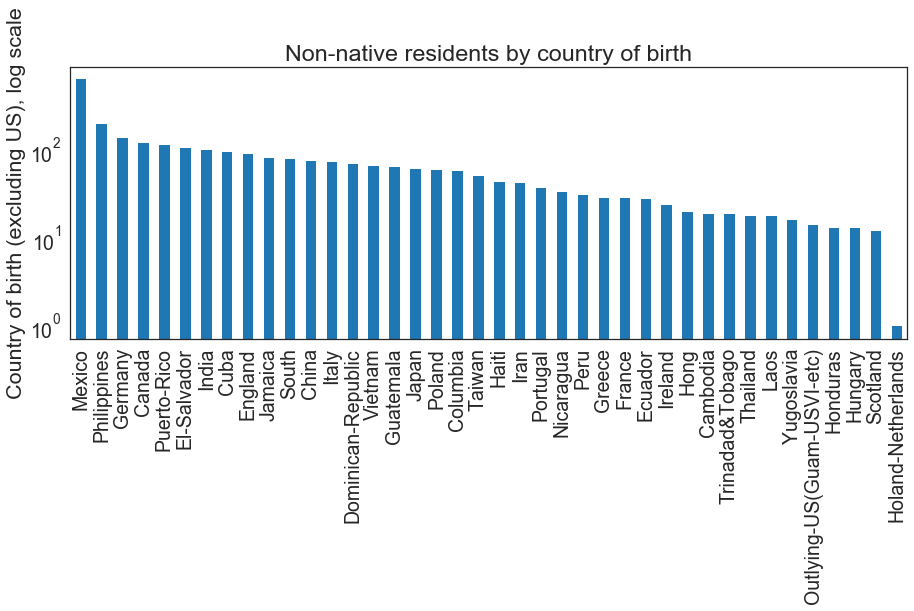

In [14]:
# plotting country of birth

sns.set_context("talk", font_scale=1.5)
sns.set_style("white")
plt.figure(figsize=(15,5))
census[census.native_country != 'United-States']['native_country'].value_counts().plot.bar()
plt.yscale('log') # log scale because the prevalence of some countries (Mexico) mask trends
plt.ylabel('Country of birth (excluding US), log scale')
plt.title('Non-native residents by country of birth')
plt.show()

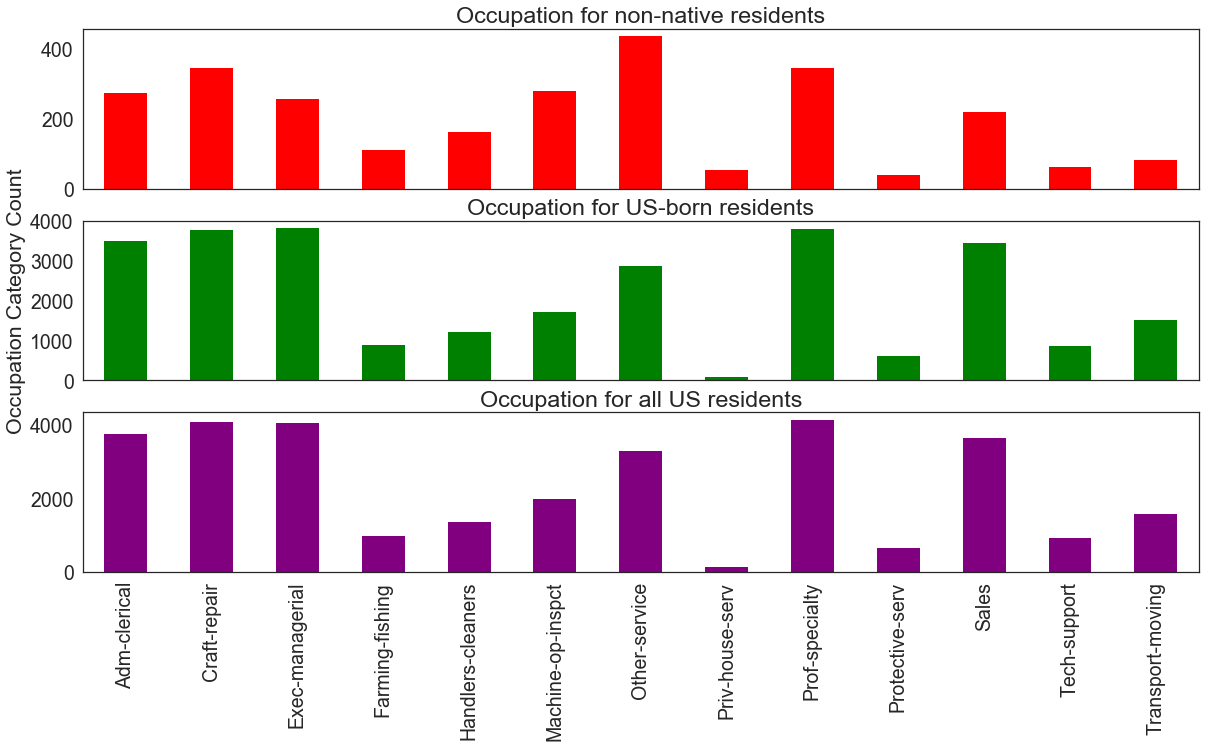

In [15]:
# plotting occupation for non-native residents

sns.set_context("talk", font_scale=1.5)
sns.set_style("white")
fig = plt.figure(figsize=[20, 10])

fig.add_subplot(3,1,1)
census[(census.native_country != 'United-States') & 
       (census.occupation != 'Armed-Forces')]['occupation'].value_counts().sort_index().plot.bar(
    color='red',sort_columns=True)
#plt.ylabel('Occupation for non-native residents')
plt.xticks([])
plt.title('Occupation for non-native residents')

fig.add_subplot(3,1,2)
census[(census.native_country == 'United-States') & 
       (census.occupation != 'Armed-Forces')]['occupation'].value_counts().sort_index().plot.bar(color = 'green',sort_columns=True)
plt.ylabel('Occupation Category Count')
plt.xticks([])
plt.title('Occupation for US-born residents')

fig.add_subplot(3,1,3)
census[census.occupation!='Armed-Forces']['occupation'].value_counts().sort_index().plot.bar(color = 'purple',sort_columns=True)
#plt.ylabel('Occupation for all residents')
plt.title('Occupation for all US residents')

plt.show()

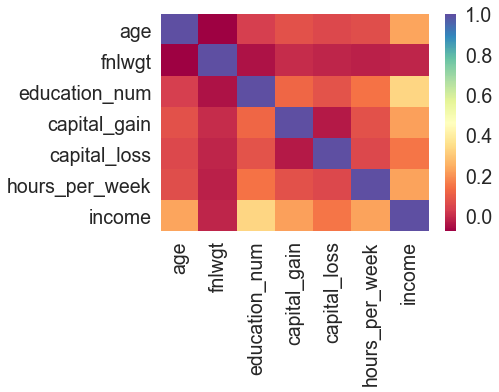

In [16]:
# Correlation matrix between numerical values
g = sns.heatmap(census[num_var].corr(), cmap = "Spectral")
plt.show()

In [17]:
# calc correlation coefficient
census[num_var].corr(method='pearson')

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,income
age,1.000000,-0.076646,0.036527,0.077674,0.057775,0.068756,0.234037
fnlwgt,-0.076646,1.000000,-0.043195,0.000432,-0.010252,-0.018768,-0.009463
education_num,0.036527,-0.043195,1.000000,0.122630,0.079923,0.148123,0.335154
capital_gain,0.077674,0.000432,0.122630,1.000000,-0.031615,0.078409,0.223329
capital_loss,0.057775,-0.010252,0.079923,-0.031615,1.000000,0.054256,0.150526
hours_per_week,0.068756,-0.018768,0.148123,0.078409,0.054256,1.000000,0.229689
income,0.234037,-0.009463,0.335154,0.223329,0.150526,0.229689,1.000000


Some small and medium correlations in the numeric data

Small correlations: 
education and capital_gain (0.122)
education and hours_per_week (0.148)
age and income (0.234)
capital_gain and income(0.223)
capital_lost and income (0.151)
income and hours_per_week (.230)

Medium correlation:
education and income (0.335)


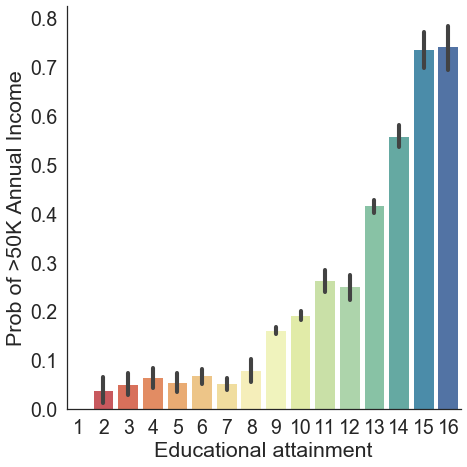

In [18]:
# Explore Education Num vs Income
g = sns.factorplot(x="education_num", y="income",data=census, kind="bar",size = 7, palette = "Spectral")
g.set_ylabels("Prob of >50K Annual Income")
g.set_ylabels("Prob of >50K Annual Income")
g.set_xlabels("Educational attainment")
plt.show()

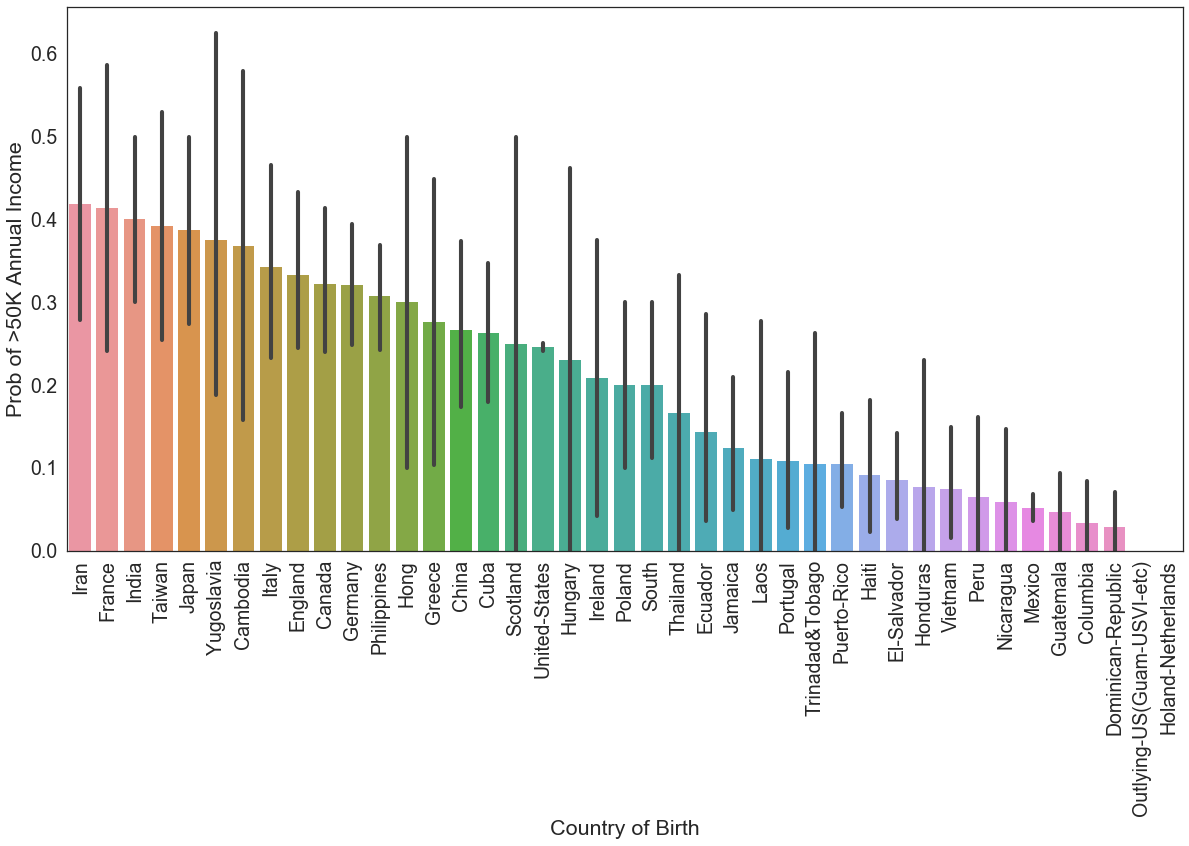

In [19]:
# Explore country of birth and probability of >50K annual income

fig = plt.figure(figsize=[20, 10])

income_prob_ranked = list(((census.groupby('native_country')['income'].mean()).sort_values(ascending=False)).index)
g = sns.barplot(x="native_country",y="income",data=census, order =income_prob_ranked)
g.set_ylabel("Prob of >50K Annual Income")
g.set_xlabel('Country of Birth')
plt.xticks(rotation=90)

plt.show()

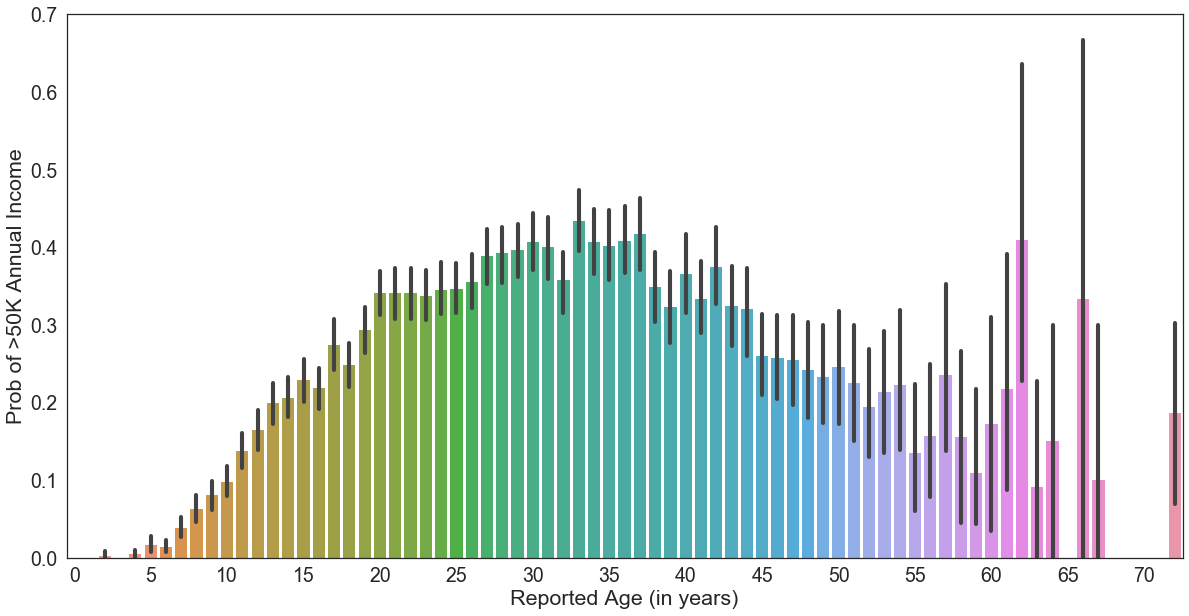

In [20]:
# Explore country of birth and probability of >50K annual income

import matplotlib.ticker as ticker
fig = plt.figure(figsize=[20, 10])
sns.set_context("talk", font_scale=1.5)


g = sns.barplot(x="age",y="income",data=census)
g.set_ylabel("Prob of >50K Annual Income")
g.set_xlabel('Reported Age (in years)')
g.xaxis.set_major_locator(ticker.MultipleLocator(5))
g.xaxis.set_major_formatter(ticker.ScalarFormatter())

plt.show()

### Prepare the data for modeling

#### Remove unwanted varaibles and Create dummies for categorical variables

In [56]:
# create copy of df for modification
census_copy = census.copy(deep=True)

In [57]:
# keep variables with some level of correlation and some demographic features that interest me
# I'm going to omit 'fnlwgt' since it is a weight metric, not technically demographic information
census_copy = census_copy[['hours_per_week', 'age', 'education_num',
       'race', 'sex', 'capital_gain', 'capital_loss', 'native_country', 'income']]

In [58]:
# new test; removed even more variables
#census_copy = census_copy[['hours_per_week', 'age', 'education_num','sex', 
#                           'capital_gain', 'capital_loss', 'income']]

In [59]:
# create new list of categorical variables
new_cat_var = []
for var in cat_var:
    if var in census_copy.columns:
        new_cat_var.append(var)

In [60]:
# create dummy variables for categorical data and remove categorical columns
census_copy = pd.concat([pd.get_dummies(census_copy[new_cat_var]), census_copy.drop(census_copy[new_cat_var], axis=1)], axis=1)

In [61]:
# create list of features names to rank importance during feature selection (below)
feature_names = list(census_copy.columns)[:-1]

In [62]:
len(census_copy.columns)

54

#### Split the training and validation set

In [63]:
# import modeling packages

from sklearn.model_selection import *

In [64]:
# create arrays of data and target

array = census_copy.values
X = array[:,0:53] # model data includes all features
y = array[:,53] # target is income group

validation_size = 0.30 # validate on 30% of the data

X_train, X_validation, y_train, y_validation = train_test_split(X,y,
    test_size=validation_size,random_state=42)

#### Training a 'baseline' classifier so I have a benchmark for my classifiers

In [65]:
# establish baseline of 'null' classifier
from sklearn.base import BaseEstimator

class Never_above_50(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [66]:
# fit baseline model and score
never_above_50_clf = Never_above_50()
cross_val_score(never_above_50_clf, X_train, y_train, cv=10, scoring="accuracy")

array([ 0.75614035,  0.74912281,  0.76919702,  0.75691093,  0.75252304,
        0.75340061,  0.75998245,  0.76129882,  0.77139096,  0.75647214])

In [67]:
# calculating the baseline of the positive case
(census.income.sum()) / (census.income.count())

0.24080955744602439

So, if I just always guess that an individual makes below 50K annually I'd be correct about 76% of the time. Let's try to beat that.

## I'm going to start with an SGD classifier with the default parameters

In [68]:
# build SGD classifier

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [69]:
# score SGD classifier
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.78862859,  0.77678336,  0.78988942])

So the 'off the shelf' SGDclassifier isn't much better than the baseline model. The 'positive' case only occurs 24.08% of the time, so if you always guess 'below 50K' you're correct 75.8% of the time.... Let's look at the confusion matrix.

In [70]:
from sklearn.model_selection import cross_val_predict

y_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)

In [71]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train, y_pred)

array([[15850,  1441],
       [ 3457,  2044]])

The confusion matrix shows that we have lots of false negatives (3457) and a few false positives (1441).

In [72]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train, y_pred)

0.58651362984218081

In [73]:
recall_score(y_train, y_pred)

0.37156880567169603

In [74]:
from sklearn.metrics import f1_score
f1_score(y_train, y_pred)

0.45492989094146447

In [75]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train, cv=3,
                             method="decision_function")

In [76]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

In [77]:
recalls.min()

0.0

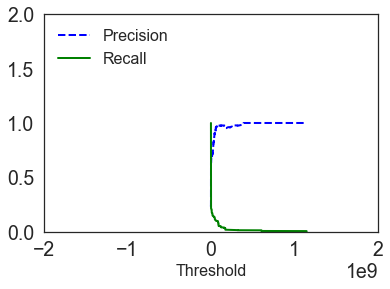

In [78]:
# plot precision and recall by threshold. this model sucks!
import matplotlib.pyplot as plt
plt.plot(thresholds,precisions[1:14989], 'b--', label="Precision", linewidth=2)
plt.plot(thresholds,recalls[1:14989], 'g-', label="Recall", linewidth=2)
plt.xlabel("Threshold", fontsize=16)
plt.legend(loc="upper left", fontsize=16)
plt.xlim([-2000000000, 2000000000])
plt.ylim([0, 2])
plt.show()

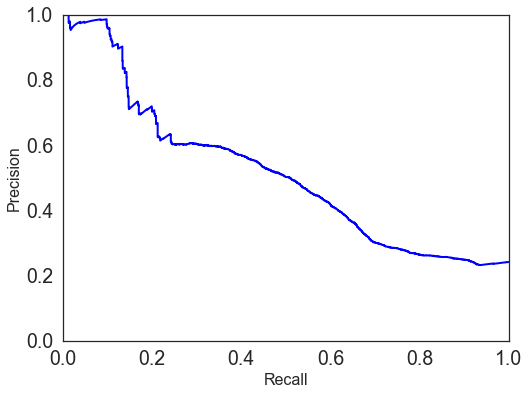

In [79]:
# plot precision and recall
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

### Plot ROC curve

In [80]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train, y_scores)

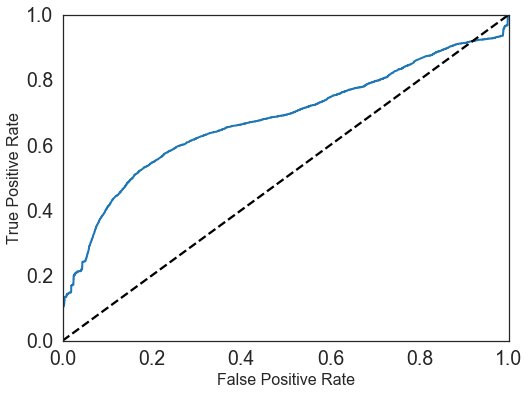

In [89]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--', label='Baseline Model')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

### Now train a Random Forest Classifier to compare

In [81]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train, cv=3,
                                    method="predict_proba")

In [82]:
forest_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [83]:
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), forest_clf.feature_importances_), feature_names), 
             reverse=True))

Features sorted by their score:
[(0.30780000000000002, 'age'), (0.18060000000000001, 'education_num'), (0.17699999999999999, 'capital_gain'), (0.17119999999999999, 'hours_per_week'), (0.069699999999999998, 'capital_loss'), (0.025100000000000001, 'sex_Male'), (0.020199999999999999, 'sex_Female'), (0.0063, 'race_White'), (0.0047999999999999996, 'native_country_United-States'), (0.0035999999999999999, 'race_Black'), (0.0025000000000000001, 'race_Asian-Pac-Islander'), (0.0023999999999999998, 'native_country_Canada'), (0.0023, 'native_country_Mexico'), (0.002, 'native_country_Philippines'), (0.0016999999999999999, 'native_country_Germany'), (0.0015, 'native_country_England'), (0.0014, 'race_Amer-Indian-Eskimo'), (0.0014, 'native_country_France'), (0.0011999999999999999, 'native_country_Iran'), (0.0011000000000000001, 'native_country_Japan'), (0.0011000000000000001, 'native_country_Italy'), (0.0011000000000000001, 'native_country_Cuba'), (0.0011000000000000001, 'native_country_China'), (0.00

In [84]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train,y_scores_forest)

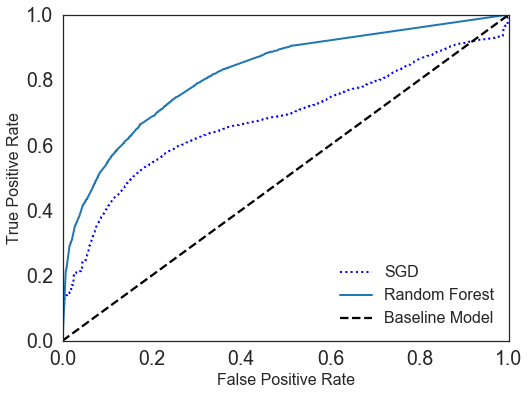

In [90]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, label="Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [91]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train, y_scores_forest)

0.82135721591768251

In [92]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train, cv=3)
precision_score(y_train, y_train_pred_forest)

0.65844095940959413

In [271]:
recall_score(y_train, y_train_pred_forest)

0.51899654608253043

In [50]:
from sklearn.metrics import classification_report

In [293]:
print('Classification report of Random Forest, default params \n')
print(classification_report(y_train, y_train_pred_forest))

Classification report of Random Forest, default params 

             precision    recall  f1-score   support

          0       0.86      0.91      0.88     17291
          1       0.66      0.52      0.58      5501

avg / total       0.81      0.82      0.81     22792



In [306]:
# try pipeline on random forest classifier

import sklearn.pipeline
from sklearn.model_selection import train_test_split

select = sklearn.feature_selection.SelectKBest(k='all')
clf = sklearn.ensemble.RandomForestClassifier()

steps = [('feature_selection', select),
        ('random_forest', clf)]

pipeline = sklearn.pipeline.Pipeline(steps)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### fit your pipeline on X_train and y_train
pipeline.fit( X_train, y_train )
### call pipeline.predict() on your X_test data to make a set of test predictions
y_prediction = pipeline.predict( X_test )
### test your predictions using sklearn.classification_report()
report = sklearn.metrics.classification_report( y_test, y_prediction )
### and print the report
print(report)

             precision    recall  f1-score   support

          0       0.85      0.92      0.89      8150
          1       0.68      0.51      0.58      2596

avg / total       0.81      0.82      0.81     10746



In [308]:
# combine pipeline and gridsearch

import sklearn.grid_search


parameters = dict(feature_selection__k=[5, 15], 
              random_forest__n_estimators=[50, 100, 200],
              random_forest__min_samples_split=[2, 3, 4, 5, 10])

cv = sklearn.grid_search.GridSearchCV(pipeline, param_grid=parameters)

cv.fit(X_train, y_train)
y_predictions = cv.predict(X_test)
report = sklearn.metrics.classification_report( y_test, y_predictions )
print(report)

/Users/jeff/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [21] are constant.
  UserWarning)
/Users/jeff/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/jeff/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [21] are constant.
  UserWarning)
/Users/jeff/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/jeff/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [21] are constant.
  UserWarning)
/Users/jeff/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f =

/Users/jeff/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [21] are constant.
  UserWarning)
/Users/jeff/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/jeff/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [21] are constant.
  UserWarning)
/Users/jeff/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/Users/jeff/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [21] are constant.
  UserWarning)
/Users/jeff/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f =

             precision    recall  f1-score   support

          0       0.86      0.94      0.90      8150
          1       0.72      0.52      0.60      2596

avg / total       0.83      0.84      0.83     10746



In [309]:
cv.best_params_

{'feature_selection__k': 15,
 'random_forest__min_samples_split': 10,
 'random_forest__n_estimators': 100}

In [310]:
cv.best_estimator_

Pipeline(steps=[('feature_selection', SelectKBest(k=15, score_func=<function f_classif at 0x1139b2598>)), ('random_forest', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, m...mators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])

In [314]:
cv.best_score_

0.8326380930552372

## So, the model still isn't great (roc_auc is 0.821), but random forest has much better recall than SVG classifier

In [93]:
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(random_state=42)
y_probas_lr = cross_val_predict(lr_clf, X_train, y_train, cv=3,
                                    method="predict_proba")

In [94]:
r2_score(y_train, y_probas_lr[:, 1])

0.31940688398341499

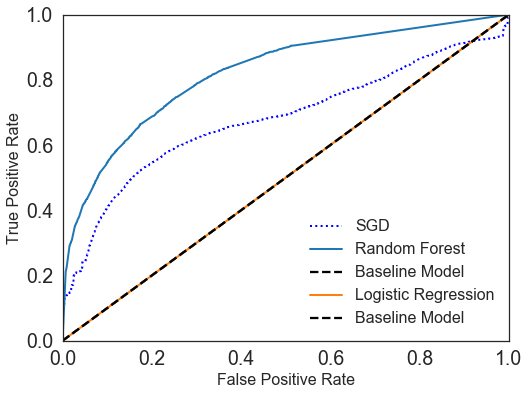

In [95]:
y_scores_lr = y_probas_lr[:, 1] # score = proba of positive class
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_train,y_scores_lr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plot_roc_curve(fpr_lr, fpr_lr, "Logistic Regression")

plt.legend(loc="lower right", fontsize=16)
plt.show()

## Experiment with regression models

Because this is a classification problem, linear regression doesn't really make sense. I'm going to try a simple Logistic Regression, then try optimizing the SGDClassifier with GridSearch to see if I can find something better. Then I'll do some feature selection with RFE, Lasso Regression (maybe if it's right for regression) and forest_clf.feature_importances_ (see above).

After feature selection I'll spend some time doing a pipeline of promising models.

In [282]:
from sklearn.feature_selection import RFE

In [96]:
# create a base classifier used to evaluate a subset of attributes
log_reg = LogisticRegression()
log_reg.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [97]:
y_pred = log_reg.predict(X_validation)

In [99]:
print('Classification report of Logistic Regression, default params \n')
print(classification_report(y_validation, y_pred))

Classification report of Logistic Regression, default params 

             precision    recall  f1-score   support

          0       0.84      0.95      0.89      7429
          1       0.72      0.44      0.55      2340

avg / total       0.81      0.82      0.81      9769



## Test out import lightgbm

In [32]:
import lightgbm as lgb

In [39]:
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer, explained_variance_score

In [42]:
def fit_model(X, y):
    """ Fits the model given X (input) and y (output var). In this case X is our
    set of specs and y is the purchase price."""

    scoring_fnc = make_scorer(r2_score)

    estimator = lgb.LGBMClassifier(num_leaves=31, verbosity=1)

    param_grid = {
        'learning_rate': [0.1, 1.0],
        'n_estimators': [50, 100, 200, 400],
        'reg_alpha': [0.1, 1],
        'max_depth': [6, 8, 10]
    }

    gbm = GridSearchCV(estimator,
                       param_grid,
                       refit=True,
                       verbose=1,
                       scoring=scoring_fnc)

    gbm.fit(X, y)

    print('Best parameters found by grid search are:', gbm.best_params_)

    return gbm

In [43]:
fit_model(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=1)]: Done 144 out of 144 | elapsed:  4.0min finished


Best parameters found by grid search are: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100, 'reg_alpha': 0.1}


GridSearchCV(cv=None, error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0, verbosity=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.1, 1.0], 'n_estimators': [50, 100, 200, 400], 'reg_alpha': [0.1, 1], 'max_depth': [6, 8, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(r2_score), verbose=1)

In [44]:
estimator = lgb.LGBMClassifier(num_leaves=31, verbosity=1, learning_rate=0.1, max_depth=8, n_estimators=100, reg_alpha=0.1)

In [45]:
estimator.fit(X_train, y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=8, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=0.1, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0, verbosity=1)

In [46]:
estimator.score(X_validation, y_validation)

0.85382331866107075

In [47]:
y_pred = estimator.predict(X_validation)

In [51]:
print('Classification report of Random Forest, default params \n')
print(classification_report(y_validation, y_pred))

Classification report of Random Forest, default params 

             precision    recall  f1-score   support

          0       0.86      0.96      0.91      7429
          1       0.81      0.51      0.63      2340

avg / total       0.85      0.85      0.84      9769



This is my best model so far. Now let's try playing with the categorical features thing:

https://github.com/Microsoft/LightGBM/blob/master/docs/Features.rst

In [52]:
y_probas_gbm = estimator.predict_proba(X_validation)

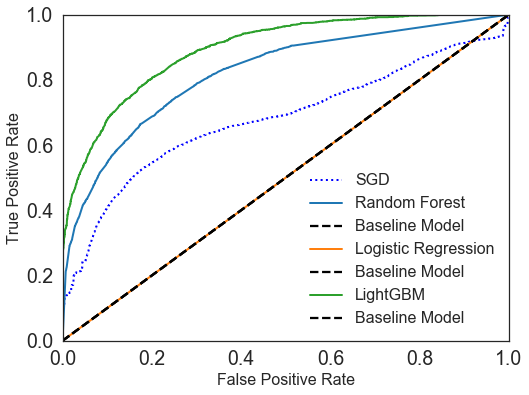

In [101]:
y_scores_gbm = y_probas_gbm[:, 1] # score = proba of positive class
fpr_gbm, tpr_gbm, thresholds_gbm = roc_curve(y_validation,y_scores_gbm)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plot_roc_curve(fpr_lr, fpr_lr, "Logistic Regression")
plot_roc_curve(fpr_gbm, tpr_gbm, "LightGBM")

plt.legend(loc="lower right", fontsize=16)
plt.show()

In [284]:
# Define dictionary to store our rankings
ranks = {}
# Create our function which stores the feature rankings to the ranks dictionary
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

In [156]:
# Finally let's run our Selection Stability method with Randomized Lasso
rlasso = RandomizedLasso()
rlasso.fit(X_train,Y_train)
ranks["rlasso/Stability"] = ranking(np.abs(rlasso.scores_), feature_names)
print('finished')

/Users/jeff/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/Users/jeff/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/Users/jeff/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/Users/jeff/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C - Cov) / (AA - corr_eq_dir + tiny))
/Users/jeff/anaconda/lib/python3.6/site-packages/sklearn/linear_model/least_angle.py:377: RuntimeWarning: overflow encountered in true_divide
  g1 = arrayfuncs.min_pos((C -

finished


In [157]:
ranks

{'rlasso/Stability': {'age': 1.0,
  'capital_gain': 1.0,
  'capital_loss': 1.0,
  'education_num': 1.0,
  'fnlwgt': 0.95999999999999996,
  'hours_per_week': 1.0,
  'native_country_Cambodia': 0.64000000000000001,
  'native_country_Canada': 0.22,
  'native_country_China': 0.20000000000000001,
  'native_country_Columbia': 0.95999999999999996,
  'native_country_Cuba': 0.11,
  'native_country_Dominican-Republic': 0.47999999999999998,
  'native_country_Ecuador': 0.22,
  'native_country_El-Salvador': 0.28999999999999998,
  'native_country_England': 0.080000000000000002,
  'native_country_France': 0.39000000000000001,
  'native_country_Germany': 0.62,
  'native_country_Greece': 0.050000000000000003,
  'native_country_Guatemala': 0.040000000000000001,
  'native_country_Haiti': 0.059999999999999998,
  'native_country_Holand-Netherlands': 0.38,
  'native_country_Honduras': 0.0,
  'native_country_Hong': 0.26000000000000001,
  'native_country_Hungary': 0.12,
  'native_country_India': 0.170000000000

### Let's try some feature selection for this

### Additional considerations

look at the types of errors made by the models (as outlined in the classification models)

definition of variables:

Age Continuous; House holder’s age
Hours-per-week Continuous; House holder’s working hours per week
Education_ num Continuous; House holder’s years of education
Capital-gain Continuous; House holder’s investment income
Capital-loss Continuous; House holder’s investment loss
Fnlwgt Continuous; Estimated number of people in the population that the sample person represents in a specific reference period.
Workclass Never-work, Without-pay, Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, and State-gov.
Education_categ Preschool, 1st-4th, 5th-6th, 7th-8th, 9th, 10th, 11th, 12th, HS-grad, Some-college, Assoc-voc, Assoc-acdm, Bachelors, Master, Prof-school, and Doctorate.
Marital-status Never-married, Separated, Widowed, Divorced, Married-spouse-absent, Married-AF-spouse, Married-civ-spouse, and Married-AF-spouse.
Occupation Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transportmoving,
Priv-house-serv, Protective-serv, and Armed-Forces.
Race White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, and Black.
Relationship Wife, Own-child, Husband, Not-in-family, Other-relative, and Unmarried
Sex Female, and Male.
Native-country United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras,
Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala,
Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad & Tobago, Peru, Hong, and Holand-Netherlands.
Income ≥50K, and <50K; Total money income of family

In [ ]:
https://www.census.gov/prod/2003pubs/censr-5.pdf

Feature selection blog:
    
http://blog.datadive.net/selecting-good-features-part-iv-stability-selection-rfe-and-everything-side-by-side/